In [36]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score

import sklearn.externals
import joblib

%matplotlib inline

#### Loading data

In [37]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

data_train.set_index('id', inplace=True)
data_train.index.name = None

data_test.set_index('id', inplace=True)
data_test.index.name = None

### Data review

In [38]:
data_train.head(3)

,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul


In [39]:
data_test.head(3)

,bone_length,rotting_flesh,hair_length,has_soul,color
3,0.471774,0.387937,0.706087,0.698537,black
6,0.427332,0.645024,0.565558,0.451462,white
9,0.549602,0.491931,0.660387,0.449809,black


In [40]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 0 to 897
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bone_length    371 non-null    float64
 1   rotting_flesh  371 non-null    float64
 2   hair_length    371 non-null    float64
 3   has_soul       371 non-null    float64
 4   color          371 non-null    object 
 5   type           371 non-null    object 
dtypes: float64(4), object(2)
memory usage: 20.3+ KB


There is no missing values


Mapping categorical data

In [41]:
data_train['color'].unique()

array(['clear', 'green', 'black', 'white', 'blue', 'blood'], dtype=object)

In [42]:
data_train['color'] = preprocessing.LabelEncoder().fit_transform(data_train['color'])
data_test['color'] = preprocessing.LabelEncoder().fit_transform(data_test['color'])

## Exploration

In [43]:
data_train.describe()

,bone_length,rotting_flesh,hair_length,has_soul,color
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,0.434160,0.506848,0.529114,0.471392,3.404313
std,0.132833,0.146358,0.169902,0.176129,1.615259
min,0.061032,0.095687,0.134600,0.009402,0.000000
25%,0.340006,0.414812,0.407428,0.348002,3.000000
50%,0.434891,0.501552,0.538642,0.466372,3.000000
75%,0.517223,0.603977,0.647244,0.600610,5.000000
max,0.817001,0.932466,1.000000,0.935721,5.000000


#### Heat map for all features

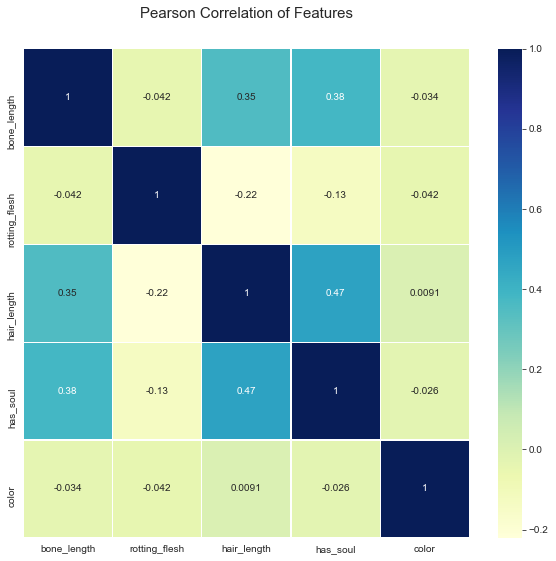

In [44]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,9))
plt.title('Pearson Correlation of Features', y=1.05, size=15);
sns.heatmap(data_train.corr(),cmap="YlGnBu", annot=True, linewidths=0.1,vmax=1.0);

There is no highly correlated features

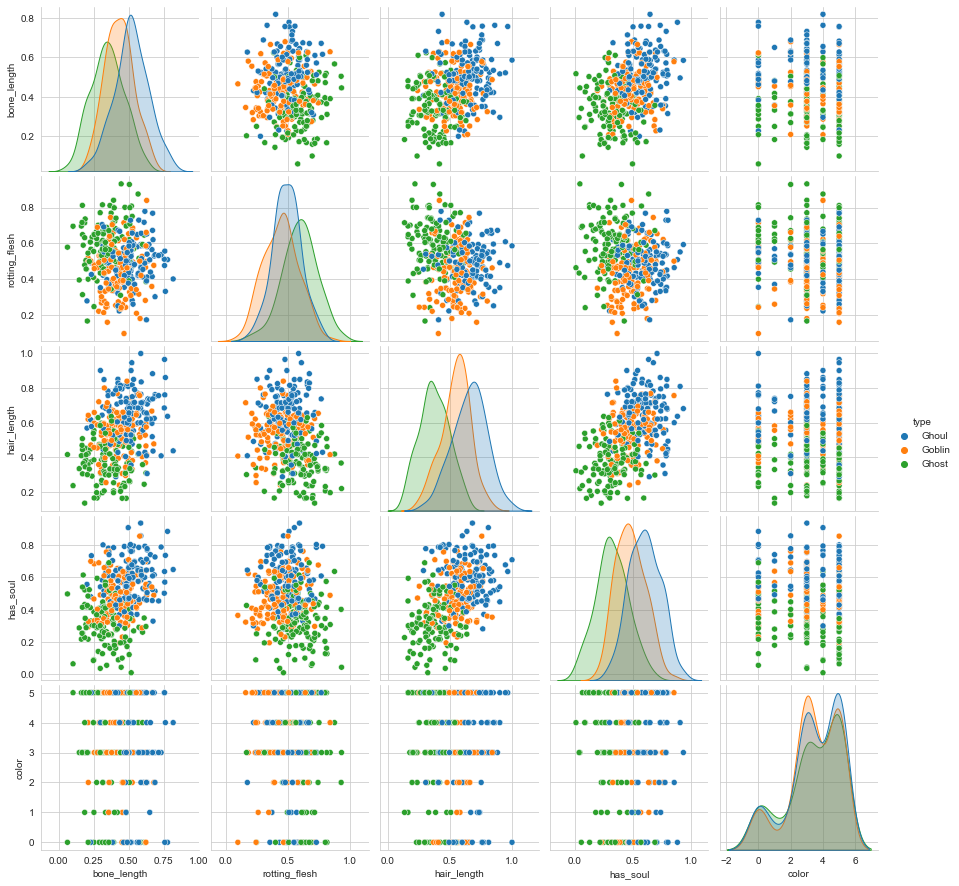

In [45]:
sns.pairplot(data_train,hue='type');

In [46]:
y = data_train['type']
X = data_train.drop('type',axis=1)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Training models:

#### Logistic Regression model:

In [48]:
params = {
        'penalty': ['l1','l2'],
        'C': [0,1, 2, 5, 10, 15]
        }
log_reg = LogisticRegression()
log_reg_grid_search = GridSearchCV(log_reg, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
log_reg_grid_search.fit(X_train,y_train)

print('Cross val accuracy: ', log_reg_grid_search.best_score_)
print('Best parameters: ', log_reg_grid_search.best_params_)


lr_clf = log_reg_grid_search.best_estimator_

Cross val accuracy:  0.7499435028248588
Best parameters:  {'C': 2, 'penalty': 'l2'}


#### K nearest neighbors:

In [49]:
params = {
        'n_neighbors': range(2,20,3),
        'weights': ['uniform', 'distance'],
        'leaf_size': range(5,50,5),
        'p': [1,2]
        }
knn = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
knn_grid_search.fit(X_train,y_train)

print('Cross val accuracy: ', knn_grid_search.best_score_)
print('Best parameters: ', knn_grid_search.best_params_)


knn_clf = knn_grid_search.best_estimator_

Cross val accuracy:  0.6927118644067797
Best parameters:  {'leaf_size': 5, 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


#### Support vector machine:

In [50]:
params = {
        'C': [0.1, 0.2, 0.5, 1, 2, 5],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': range(3,12,2),
        }
svm = SVC()
svm_grid_search = GridSearchCV(svm, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
svm_grid_search.fit(X_train,y_train)

print('Cross val accuracy: ', svm_grid_search.best_score_)
print('Best parameters: ', svm_grid_search.best_params_)


svm_clf = svm_grid_search.best_estimator_

Cross val accuracy:  0.7429378531073446
Best parameters:  {'C': 5, 'degree': 3, 'kernel': 'linear'}


#### Random Forest:

In [51]:
params = {
        'n_estimators': [20, 50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': range(10,110,10),
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [4, 8, 10],
        }
rfc = RandomForestClassifier()
rfc_grid_search = GridSearchCV(rfc, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
rfc_grid_search.fit(X_train,y_train)

print('Cross val accuracy: ', rfc_grid_search.best_score_)
print('Best parameters: ', rfc_grid_search.best_params_)


rfc_clf = svm_grid_search.best_estimator_

Cross val accuracy:  0.7430508474576272
Best parameters:  {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 50}


#### Gradient Boosting

In [52]:
params = {
        'learning_rate': [0.001, 0.05, 0.1, 0.2, 0.3],
        'n_estimators': [50, 100, 200, 500],
        'subsample': [0.8],
        'max_depth': [2, 3, 5, 10, 12],
        }
gbc = GradientBoostingClassifier()
gbc_grid_search = GridSearchCV(gbc, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
gbc_grid_search.fit(X_train,y_train)

print('Cross val accuracy: ', gbc_grid_search.best_score_)
print('Best parameters: ', gbc_grid_search.best_params_)


gb_clf = gbc_grid_search.best_estimator_

Cross val accuracy:  0.7465536723163841
Best parameters:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


In [53]:
voting_clf = VotingClassifier(estimators=[('lr', lr_clf), ('knn', knn_clf), ('svm', svm_clf), ('rf', rfc_clf), ('gb', gb_clf)],
                              voting='hard')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print('Accuracy score on test: ', accuracy_score(y_test,y_pred))

Accuracy score on test:  0.7333333333333333


In [54]:
joblib.dump(voting_clf,'data/models/voting_classifier')

['data/models/voting_classifier']

In [55]:
predictions = voting_clf.predict(data_test)

In [59]:
result = pd.Series(index=data_test.index,data=predictions)

In [61]:
result.to_csv('data/result.csv')